# Distortions

This notebook reproduces figures 8 and 9 as well as the stats in section 3.2.4

### Orientation theory

This is how the orientation maps onto the x, y, and z axes in the template space and the encoding directions for the different scans.

| Scan | PE Dir | FE Dir | PE design | FE design | BW [Hz]|
|------|--------|--------|-----------|-----------|--------|
| Axi  | AP     | RL     | Y         | X         | 571.4  |
| Sag  | SI     | AP     | Z         | Y         | 470.6  |
| Cor  | RL     | SI     | X         | Z         | 516.1  |

Template data dimensions

| X  | Y  | Z  |
|----|----|----|
| RL | AP | SI |

For this analysis we use the rigid body registration between fiducial coordinates and the design space, this is indicated by the label `UNetAxisRigid`.

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import statsmodels.formula.api as smf

from dataframe_help import add_temperature_w0_sw
from distortions_help import load_distortions_df, calc_mean_2D_dist_radius

In [36]:
# Sequence parameters
FE = {'axi':136,'cor':124, 'sag':124}
temp_dir = {'X':'RL', 'Y':'AP', 'Z':'SI'}

encoding_dir = {'axi':{'phase':'y', 'frequency':'x', 'slice':'z'},
                    'sag':{'phase':'z', 'frequency':'y', 'slice':'x'},
                    'cor':{'phase':'x', 'frequency':'z', 'slice':'y'}}

encoding_dir_inv = {}
for ax in encoding_dir.keys():
    encoding_dir_inv[ax] = {}
    for k in ['phase', 'frequency', 'slice']:
        encoding_dir_inv[ax][encoding_dir[ax][k]] = k

In [37]:
# Remove sessions+axis variations larger than 20 mm, registration/segmentation error
df = load_distortions_df()
df = add_temperature_w0_sw(df, '../data')
mean_rad_df = calc_mean_2D_dist_radius(df)

Removed 6 sessions


Adding in temperature, w0 and SW: 100%|██████████| 9750/9750 [00:05<00:00, 1745.07it/s]


## Figure 8 A-C

/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_42639/397991742.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()


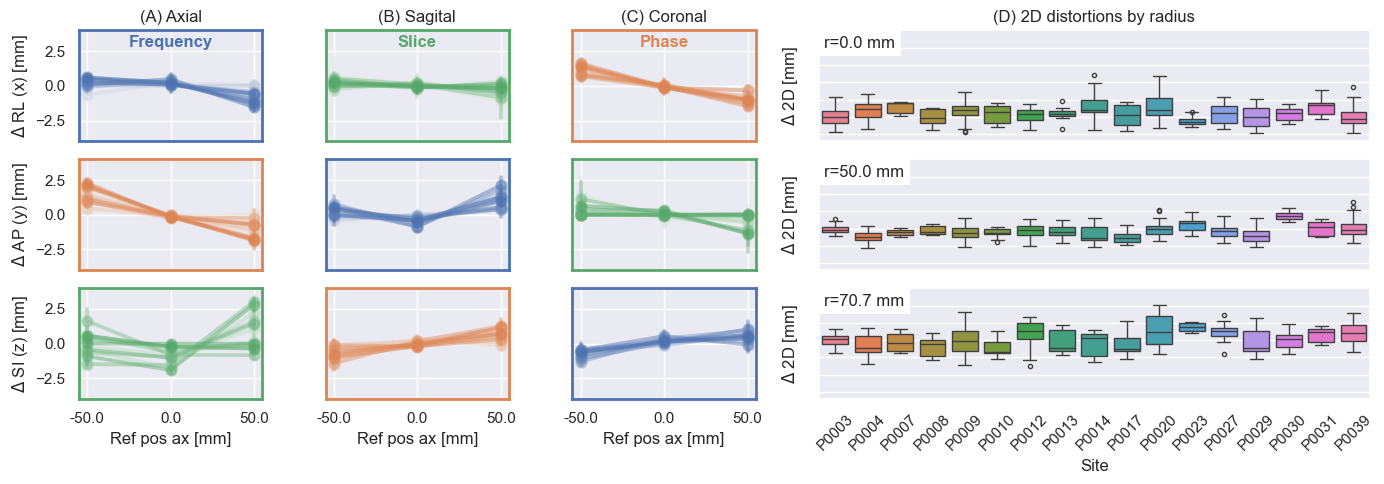

In [39]:
# Figure showing distortions along phase, frequency and slice encoding direction
sns.set_theme()
fig, axes = plt.subplots(3,4,figsize=(14,5), width_ratios=[1,1,1,3], layout='tight')
my_colors = {'frequency':'C00', 'phase':'C01', 'slice':'C02'}

for icol,my_or in enumerate(['axi', 'sag', 'cor']):
    for irow,my_ax in enumerate(['x', 'y', 'z']):
        
        plot_color = my_colors[encoding_dir_inv[my_or][my_ax]]
        sns.pointplot(data=df.loc[df['Axis']==my_or], x=f'{my_ax}_ref', y=f'{my_ax}_diff', hue='Subject', ax=axes[irow,icol], alpha=0.5, palette=f'light:{plot_color}')
        axes[irow,icol].set_ylim([-4,4])

        if irow==0:
            axes[irow,icol].set_title(my_or)
    
for ax in axes.flatten():
    ax.legend().remove()

for ax in axes[:-1,:].flatten():
    ax.set_xlabel(None)
    ax.set_xticklabels([])

for ax in axes[:,1:].flatten():
    ax.set_ylabel(None)
    ax.set_yticklabels([])

axes[0,0].set_ylabel(r'$\Delta$ RL (x) [mm]')
axes[1,0].set_ylabel(r'$\Delta$ AP (y) [mm]')
axes[2,0].set_ylabel(r'$\Delta$ SI (z) [mm]')

x = 1
y = 3.1
text_opt = {"verticalalignment":'center', "horizontalalignment":'center', "fontweight":'bold'}

axes[0,0].text(x, y, 'Frequency', color=my_colors['frequency'], **text_opt)
axes[0,2].text(x, y, 'Phase', color=my_colors['phase'], **text_opt)
axes[0,1].text(x, y, 'Slice', color=my_colors['slice'], **text_opt)

axes[0,0].set_title("(A) Axial")
axes[0,1].set_title("(B) Sagital")
axes[0,2].set_title("(C) Coronal")

for ax in [axes[0,0], axes[1,1], axes[2,2]]:
    for spine in ax.spines.values():
        spine.set_edgecolor(my_colors['frequency'])
        spine.set_linewidth(2)

for ax in [axes[1,0], axes[2,1], axes[0,2]]:
    for spine in ax.spines.values():
        spine.set_edgecolor(my_colors['phase'])
        spine.set_linewidth(2)

for ax in [axes[2,0], axes[0,1], axes[1,2]]:
    for spine in ax.spines.values():
        spine.set_edgecolor(my_colors['slice'])
        spine.set_linewidth(2)

for ax in axes[2,:].flatten():
    ax.set_xlabel('Ref pos ax [mm]')

for ax in axes[:3,:3].flatten():
    ax.grid('both')
    ax.set_xlim([-0.1, 2.1])

# Subplot D
sns.boxplot(mean_rad_df.loc[mean_rad_df.r_ref_level=='0.0'], x='Subject', y='Mean_2D', hue='Subject', flierprops={"marker": "."}, ax=axes[0,3])
sns.boxplot(mean_rad_df.loc[mean_rad_df.r_ref_level=='50.0'], x='Subject', y='Mean_2D',hue='Subject',flierprops={"marker": "."}, ax=axes[1,3])
sns.boxplot(mean_rad_df.loc[mean_rad_df.r_ref_level=='70.7'], x='Subject', y='Mean_2D',hue='Subject',flierprops={"marker": "."}, ax=axes[2,3])

axes[0,3].text(-.35, 2.5, 'r=0.0 mm', bbox=dict(facecolor='white', edgecolor='none'), ha='left')
axes[1,3].text(-.35, 2.5, 'r=50.0 mm', bbox=dict(facecolor='white', edgecolor='none'), ha='left')
axes[2,3].text(-.35, 2.5, 'r=70.7 mm', bbox=dict(facecolor='white', edgecolor='none'), ha='left')

for ax in axes[:2,3]:
    ax.set_xlabel(None)
    ax.set_xticklabels([])

for ax in axes[:,3]:
    ax.set_ylim([-.2,3])
    ax.set_yticks([0,.5,1,1.5,2,2.5])
    ax.set_ylabel('$\Delta$ 2D [mm]')

axes[2,3].tick_params(axis='x', rotation=45)
axes[2,3].set_xlabel('Site')
axes[0,3].set_title('(D) 2D distortions by radius')

plt.savefig('../results/figure8_encoding_distortions.png', dpi=300)
plt.show()

In [24]:
# Mean in difference between sites
for rad in ['0.0', '50.0', '70.7']:
    mm = mean_rad_df.loc[mean_rad_df.r_ref_level==rad, 'Mean_2D'].mean()
    sub_means = []
    for sub in mean_rad_df.Subject.unique():
        sub_means.append(mean_rad_df.loc[(mean_rad_df.r_ref_level==rad) & (mean_rad_df.Subject==sub), 'Mean_2D'].mean())

    print(f"Rad={rad}. Mean:{mm:.3f} (Min: {min(sub_means):.3f}, Max:{max(sub_means):.3f})")

Rad=0.0. Mean:0.594 (Min: 0.392, Max:0.828)
Rad=50.0. Mean:0.926 (Min: 0.746, Max:1.373)
Rad=70.7. Mean:1.533 (Min: 1.265, Max:1.873)


In [25]:
# Check which factors that influence the magnitude distortion
formula = 'Mean_2D ~ Temperature + radius + C(Subject) + C(Axis)'
model = smf.ols(formula, data=mean_rad_df).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

print(anova_results)

                 sum_sq      df            F        PR(>F)
C(Subject)    10.982635    16.0     7.198060  1.661753e-16
C(Axis)        3.182762     2.0    16.687951  6.523784e-08
Temperature    0.173717     1.0     1.821676  1.772722e-01
radius       249.677030     1.0  2618.228130  0.000000e+00
Residual     183.951500  1929.0          NaN           NaN


## Figure 9: Distortion quiver plot 

In [29]:
from ghost.phantom import Caliber137
import nibabel as nib
from scipy.ndimage import center_of_mass
import matplotlib as mpl
import ants

plt.style.use('dark_background')

In [80]:
phantom = Caliber137()
img = ants.image_read(phantom.get_phantom_nii(weighting='T1w')).numpy()
fid = ants.image_read(phantom.get_seg_nii('fiducials')).numpy()

In [81]:
df_master = load_distortions_df()
df_master.head()

Removed 6 sessions


,LabelValue,x_org,y_org,z_org,x_ref,y_ref,z_ref,x_reg,y_reg,z_reg,...,Run,Subject,Session,Method,Date,BW,r_ref,3D_diff,2D_diff,r_ref_level
0,1,85.0,54.400001,-49.600001,0.0,50.0,50.0,-0.392082,49.621128,47.854862,...,1,P0003,20230927164642,UNetAxisRigid,2023-09-27,0.002125,70.710678,2.213343,2.178339,70.7
1,2,135.0,102.400002,-48.000001,-50.0,0.0,50.0,-50.006134,1.264694,50.435455,...,1,P0003,20230927164642,UNetAxisRigid,2023-09-27,0.002125,70.710678,1.337576,1.337562,70.7
2,3,85.0,155.200002,-51.200001,0.0,-50.0,50.0,0.415276,-51.187340,48.303493,...,1,P0003,20230927164642,UNetAxisRigid,2023-09-27,0.002125,70.710678,2.111957,2.070727,70.7
3,4,35.0,104.000002,-49.600001,50.0,0.0,50.0,50.003548,0.433365,48.857220,...,1,P0003,20230927164642,UNetAxisRigid,2023-09-27,0.002125,70.710678,1.222197,1.222191,70.7
4,5,85.0,104.000002,-49.600001,0.0,0.0,50.0,0.005150,0.032959,48.862755,...,1,P0003,20230927164642,UNetAxisRigid,2023-09-27,0.002125,50.000000,1.137734,1.137723,50.0


In [82]:
def make_quiver_plot(df0, scan_ax, rot=True):
    fig, axes = plt.subplots(1,3,figsize=(12,4))
    fiducials = {'axi':[[1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15]],
                'sag':[[4,9,14], [3,5,1,8,10,6,13,15,11], [2,7,12]],
                'cor':[[1,6,11], [4,5,2,9,10,7,14,15,12], [3,8,13]]}
    
    df = df0.loc[df0.Axis==scan_ax]

    for p in range(3):
        for i in fiducials[scan_ax][p]:
            vi = i
            m = df.loc[df['LabelValue']==vi, '2D_diff'].mean()
            s = df.loc[df['LabelValue']==vi, '2D_diff'].mean()

            dx = df.loc[df['LabelValue']==vi, 'x_diff'].mean()
            dy = df.loc[df['LabelValue']==vi, 'y_diff'].mean()
            dz = df.loc[df['LabelValue']==vi, 'z_diff'].mean()

            nx,ny,nz = img.shape
            
            x,y,z = center_of_mass(fid==vi)
            k = 7
            mk = 150
            cmap = 'plasma'
            if scan_ax=='axi':
                sc = axes[p].scatter(y, x, s=m*mk, c=s, cmap=cmap, vmin=0, vmax=3)
                axes[p].imshow(img[:,:,int(z)], cmap='gray', vmin=0, vmax=2000)
                axes[p].arrow(y, x, dy*k, dx*k, linewidth=2, color='w', width=1, alpha=1)
            
            elif scan_ax=='cor':
                sc = axes[p].scatter(z, x, s=m*mk, c=s, cmap=cmap, vmin=0, vmax=3)
                axes[p].imshow(img[:,int(y),:], cmap='gray', vmin=0, vmax=2000)
                axes[p].arrow(z, x, dz*k, dx*k, linewidth=2, color='w', width=1, alpha=1)

            elif scan_ax=='sag':
                sc = axes[p].scatter(z, y, s=m*mk, c=s, cmap=cmap, vmin=0, vmax=3)
                axes[p].imshow(img[int(x),:,:], cmap='gray', vmin=0, vmax=2000)
                axes[p].arrow(z, y, dz*k, dy*k, linewidth=2, color='w', width=1, alpha=1)

    if scan_ax=='axi':
        lims = [30,256-30,30,256-30]
    elif scan_ax=='cor':
        lims = [10,192-25,30,256-30]
    elif scan_ax=='sag':
        lims = [10,192-25,30,256-30]
    
    for ax in axes:
        ax.axis(lims)
        ax.axis('off')

    plt.tight_layout()
    axes[2].arrow(128, 40, 1*k, 0, linewidth=2, color='w', width=1, alpha=1)
    axes[2].text(128+15, 40, '1 mm', color='w', va='center', fontsize=20)


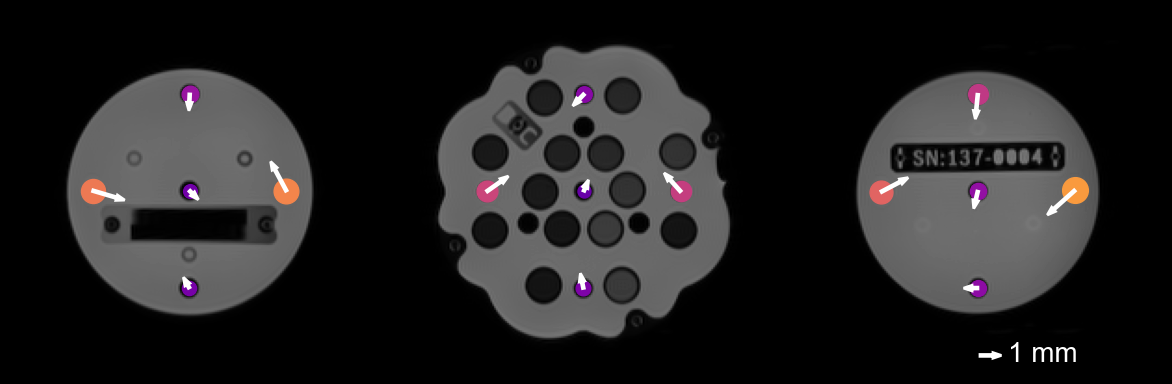

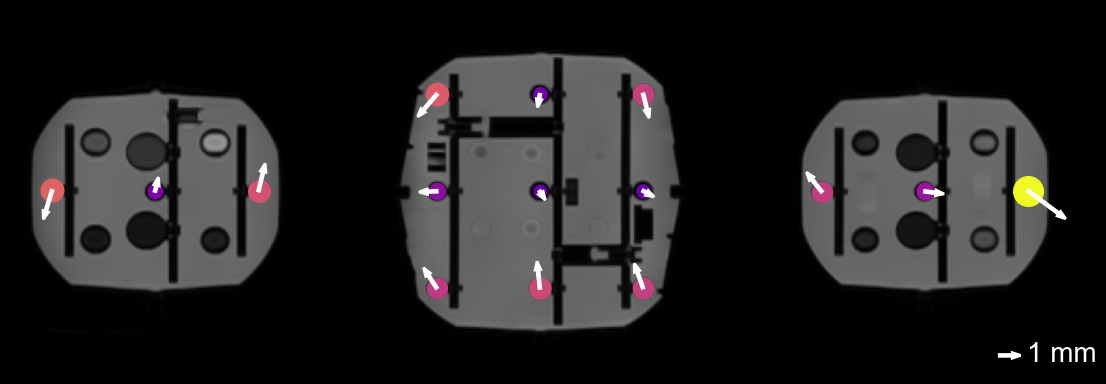

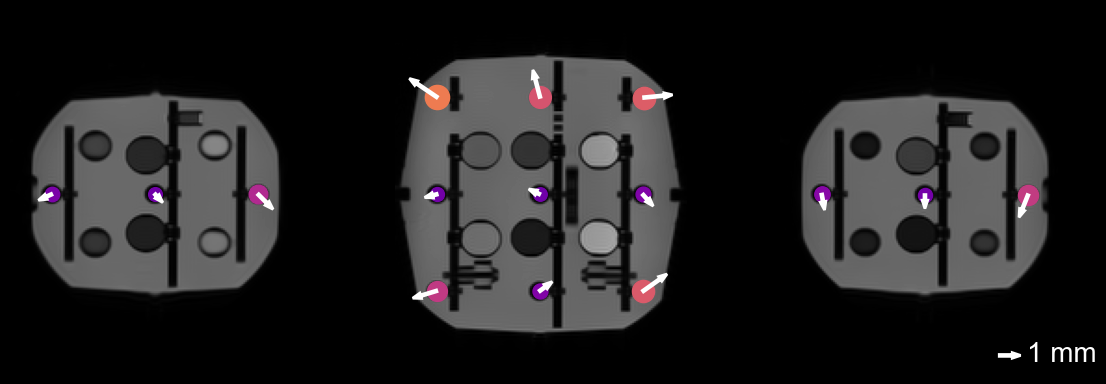

In [84]:
plt.style.use('dark_background')
make_quiver_plot(df_master, 'axi'); plt.show()
make_quiver_plot(df_master, 'cor'); plt.show()
make_quiver_plot(df_master, 'sag'); plt.show()

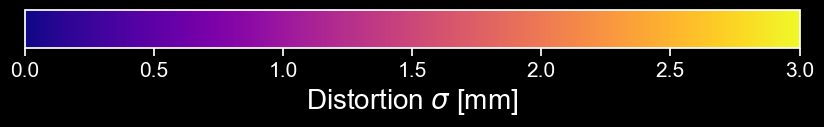

In [34]:
fig, ax = plt.subplots(figsize=(10, .5))
norm = mpl.colors.Normalize(vmin=0, vmax=3)
cb = mpl.colorbar.ColorbarBase(ax, cmap='plasma', norm=norm, orientation='horizontal')
cb.set_label('Distortion $\sigma$ [mm]', fontsize=20)
cb.ax.tick_params(labelsize=15)
plt.show()

## Selection of other figures

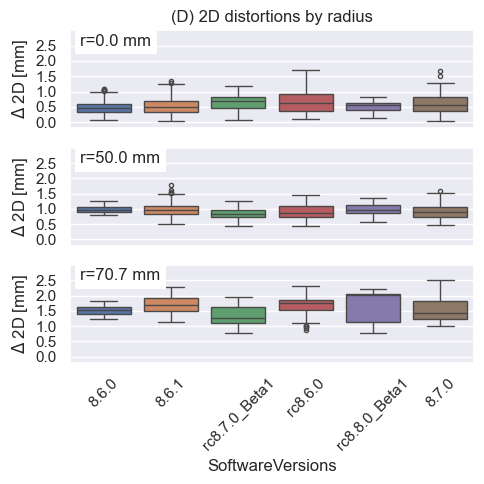

In [22]:
# Look at the range of distortions in 2D
fig, axes = plt.subplots(3,1, figsize=(5,5))
sns.boxplot(mean_rad_df.loc[mean_rad_df.r_ref_level=='0.0'], x='SoftwareVersions', y='Mean_2D', hue='SoftwareVersions', flierprops={"marker": "."}, ax=axes[0])
sns.boxplot(mean_rad_df.loc[mean_rad_df.r_ref_level=='50.0'], x='SoftwareVersions', y='Mean_2D',hue='SoftwareVersions',flierprops={"marker": "."}, ax=axes[1])
sns.boxplot(mean_rad_df.loc[mean_rad_df.r_ref_level=='70.7'], x='SoftwareVersions', y='Mean_2D',hue='SoftwareVersions',flierprops={"marker": "."}, ax=axes[2])

axes[0].text(-.35, 2.5, 'r=0.0 mm', bbox=dict(facecolor='white', edgecolor='none'), ha='left')
axes[1].text(-.35, 2.5, 'r=50.0 mm', bbox=dict(facecolor='white', edgecolor='none'), ha='left')
axes[2].text(-.35, 2.5, 'r=70.7 mm', bbox=dict(facecolor='white', edgecolor='none'), ha='left')

for ax in axes[:2]:
    ax.set_xlabel(None)
    ax.set_xticklabels([])

for ax in axes:
    ax.set_ylim([-.2,3])
    ax.set_yticks([0,.5,1,1.5,2,2.5])
    ax.set_ylabel('$\Delta$ 2D [mm]')

axes[2].tick_params(axis='x', rotation=45)
axes[0].set_title('(D) 2D distortions by radius')
plt.tight_layout()
plt.show()

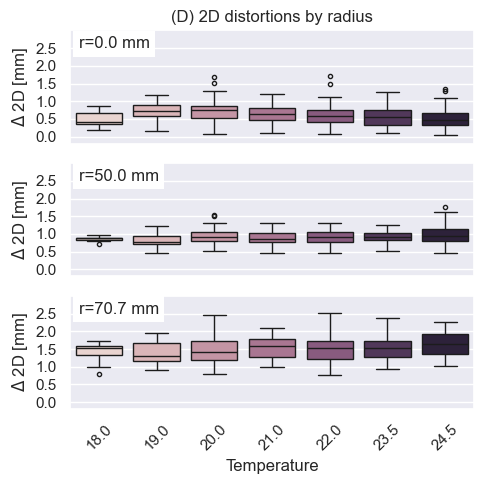

/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_42639/3956691010.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Sagital','Coronal', 'Axial'])


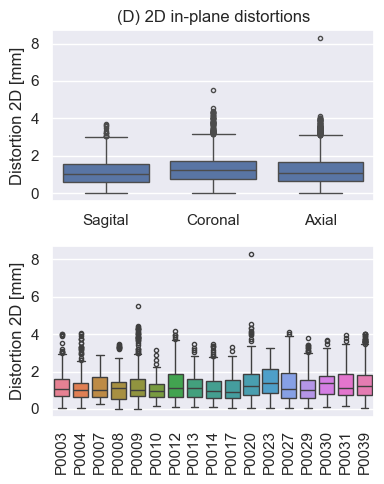

In [23]:
# Look at the range of distortions in 2D
fig, axes = plt.subplots(3,1, figsize=(5,5))
sns.boxplot(mean_rad_df.loc[mean_rad_df.r_ref_level=='0.0'], x='Temperature', y='Mean_2D', hue='Temperature', flierprops={"marker": "."}, ax=axes[0])
sns.boxplot(mean_rad_df.loc[mean_rad_df.r_ref_level=='50.0'], x='Temperature', y='Mean_2D',hue='Temperature',flierprops={"marker": "."}, ax=axes[1])
sns.boxplot(mean_rad_df.loc[mean_rad_df.r_ref_level=='70.7'], x='Temperature', y='Mean_2D',hue='Temperature',flierprops={"marker": "."}, ax=axes[2])

axes[0].text(-.35, 2.5, 'r=0.0 mm', bbox=dict(facecolor='white', edgecolor='none'), ha='left')
axes[1].text(-.35, 2.5, 'r=50.0 mm', bbox=dict(facecolor='white', edgecolor='none'), ha='left')
axes[2].text(-.35, 2.5, 'r=70.7 mm', bbox=dict(facecolor='white', edgecolor='none'), ha='left')

for ax in axes[:2]:
    ax.set_xlabel(None)
    ax.set_xticklabels([])

for ax in axes:
    ax.set_ylim([-.2,3])
    ax.set_yticks([0,.5,1,1.5,2,2.5])
    ax.set_ylabel('$\Delta$ 2D [mm]')
    ax.legend().remove()

axes[2].tick_params(axis='x', rotation=45)
axes[0].set_title('(D) 2D distortions by radius')
plt.tight_layout()
plt.show()

# Look at the range of distortions in 2D
fig, axes = plt.subplots(2,1, figsize=(4,5))
sns.boxplot(df, x='Axis', y='2D_diff', ax=axes[0], flierprops={"marker": "."},)
sns.boxplot(df, x='Subject', y='2D_diff', hue='Subject', ax=axes[1], flierprops={"marker": "."})
axes[1].tick_params(axis='x', rotation=90)
axes[0].set_xticklabels(['Sagital','Coronal', 'Axial'])
axes[0].set_xlabel(None)
axes[1].set_xlabel(None)
axes[0].set_ylabel('Distortion 2D [mm]')
axes[1].set_ylabel('Distortion 2D [mm]')
axes[0].set_title('(D) 2D in-plane distortions')
plt.tight_layout()
plt.show()

/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_42639/123122728.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1,3].legend().remove()
/var/folders/ny/6dp1qmz157q4n82n0s_79v3c0000gn/T/ipykernel_42639/123122728.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2,3].legend().remove()


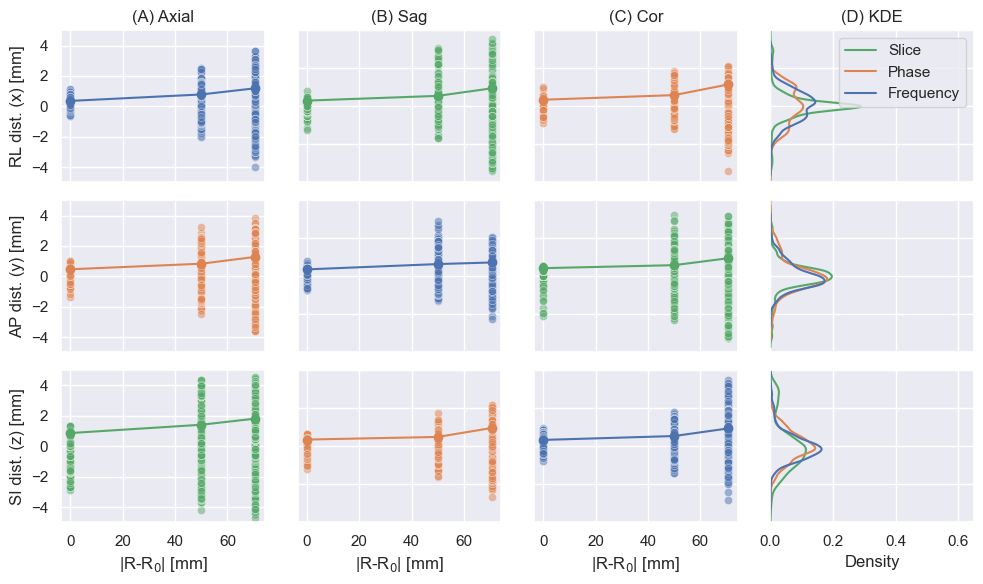

In [26]:
# color code freq (0), phase (1), slice (2)
dir_color = {'axi':{'x':0,'y':1, 'z':2},
             'sag':{'x':2, 'y':0, 'z':1},
             'cor':{'x':1, 'y':2, 'z':0}}

fig, axes = plt.subplots(3,4,figsize=(10,6))
for icol, my_scan in enumerate(['axi', 'sag', 'cor']):
    for irow, my_ax in enumerate(['x', 'y', 'z']):
        my_color = f'C0{dir_color[my_scan][my_ax]}'
        sns.scatterplot(data=df.loc[df['Axis']==my_scan], x='r_ref', y=f'{my_ax}_diff', ax=axes[irow,icol], color=my_color, alpha=0.5)

        sd_list = [df.loc[(df['Axis']==my_scan) & (df['r_ref_level']==x), f'{my_ax}_diff'].std() for x in ['0.0', '50.0', '70.7']]
        axes[irow,icol].plot([0, 50, 70.7], sd_list, '-o', color=my_color)

sns.kdeplot(data=df, y='x_diff', hue='Axis', ax=axes[0,3], hue_order=['axi', 'cor', 'sag'])
sns.kdeplot(data=df, y='y_diff', hue='Axis', ax=axes[1,3], hue_order=['sag', 'axi', 'cor'])
sns.kdeplot(data=df, y='z_diff', hue='Axis', ax=axes[2,3], hue_order=['cor', 'sag', 'axi'])

for ax in axes[:-1,:].flatten():
    ax.set_xlabel(None)
    ax.set_xticklabels([])

for ax in axes[:,1:].flatten():
    ax.set_ylabel(None)
    ax.set_yticklabels([])

for ax in axes[:,0].flatten():
    ax.set_yticks([-4, -2, 0, 2, 4])

axes[0,0].set_title('(A) Axial')
axes[0,1].set_title('(B) Sag')
axes[0,2].set_title('(C) Cor')

axes[0,0].set_ylabel('RL dist. (x) [mm]')
axes[1,0].set_ylabel('AP dist. (y) [mm]')
axes[2,0].set_ylabel('SI dist. (z) [mm]')

for ax in axes[2,:].flatten():
    ax.set_xlabel(r'|R-R$_0$| [mm]')

for ax in axes[:,3].flatten():
    # ax.legend().remove()
    ax.set_xlim([0, .65])

for ax in axes.flatten():
    ax.set_ylim([-5,5])

axes[0,3].legend(['Slice', 'Phase', 'Frequency'])
axes[1,3].legend().remove()
axes[2,3].legend().remove()

axes[0,3].set_title('(D) KDE')
axes[2,3].set_xlabel('Density')

plt.tight_layout()
plt.show()